## Analyze the learned reward function

In [1]:
env = "HalfCheetah-v5"
algo = "ppo"
seed = 12
num_samples = 500

In [2]:
import pickle as pkl
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from rlhf.networks import LightningNetwork

#with open(f"feedback/ppo_{env}_{seed}.pkl", "rb") as file:
#    data = pkl.load(file)



all_in = []
all_rews = []
for idx, seg in enumerate(data["segments"]):
    all_in.extend([(s[0].squeeze(),s[1]) for s in seg])
    all_rews.extend([s[2] for s in seg])
all_rews = np.array(all_rews)

In [3]:
import random

indices = random.sample(range(len(all_in)), num_samples)

# Sample from both lists using the same indices
input_data = [all_in[i] for i in indices]
rews = all_rews[indices]

In [4]:
import os

#rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference", "cluster_description"]
rew_fn_types = ["corrective"]
reward_functions = []

base_dir = "reward_models"
rew_functions = []
for type in rew_fn_types:
    rew_functions.append(os.path.join(base_dir, f"{algo}_{env}_{seed}_{type}_{seed}.ckpt"))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
 
def pairwise_correlation_heatmap(rewards, names=None):    
    # Compute correlation matrix
    n_functions = rewards.shape[0]
    corr_matrix = np.zeros((n_functions, n_functions))
    for i in range(n_functions):
        for j in range(n_functions):
            corr, _ = pearsonr(rewards[i], rewards[j])
            corr_matrix[i, j] = np.mean(corr)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Set labels
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    plt.title('Pairwise Correlations of Reward Functions')
    plt.tight_layout()
    plt.show()

In [6]:
import torch

device = "cpu" if not torch.cuda.is_available() else "cuda:0"

def reward_fn(reward_model_path):
    return lambda input: LightningNetwork.load_from_checkpoint(
                reward_model_path,
                map_location=device
            )(torch.as_tensor(np.array([input[0]] * 4), device=device, dtype=torch.float).unsqueeze((1)),torch.as_tensor(np.array([input[1]] * 4), device=device, dtype=torch.float).unsqueeze(1))

n_functions = len(reward_functions)

# Compute rewards for all functions
pred_rewards = []
pred_std = []
for i, path in enumerate(rew_functions):
    func = reward_fn(path)
    with torch.no_grad():
        preds = torch.vstack([func(x).squeeze() for x in input_data])
        pred_rewards.append(torch.mean(preds, axis=1).cpu().numpy())
        pred_std.append(torch.mean(preds, axis=1).cpu().numpy())
        print(f"Finished {i+1}/{len(rew_functions)} rew. function")

Finished 1/1 rew. function


In [7]:
in_names = ["Ground Truth"] + rew_fn_types

pred_rewards = [rews] + [pr.squeeze() for pr in pred_rewards]

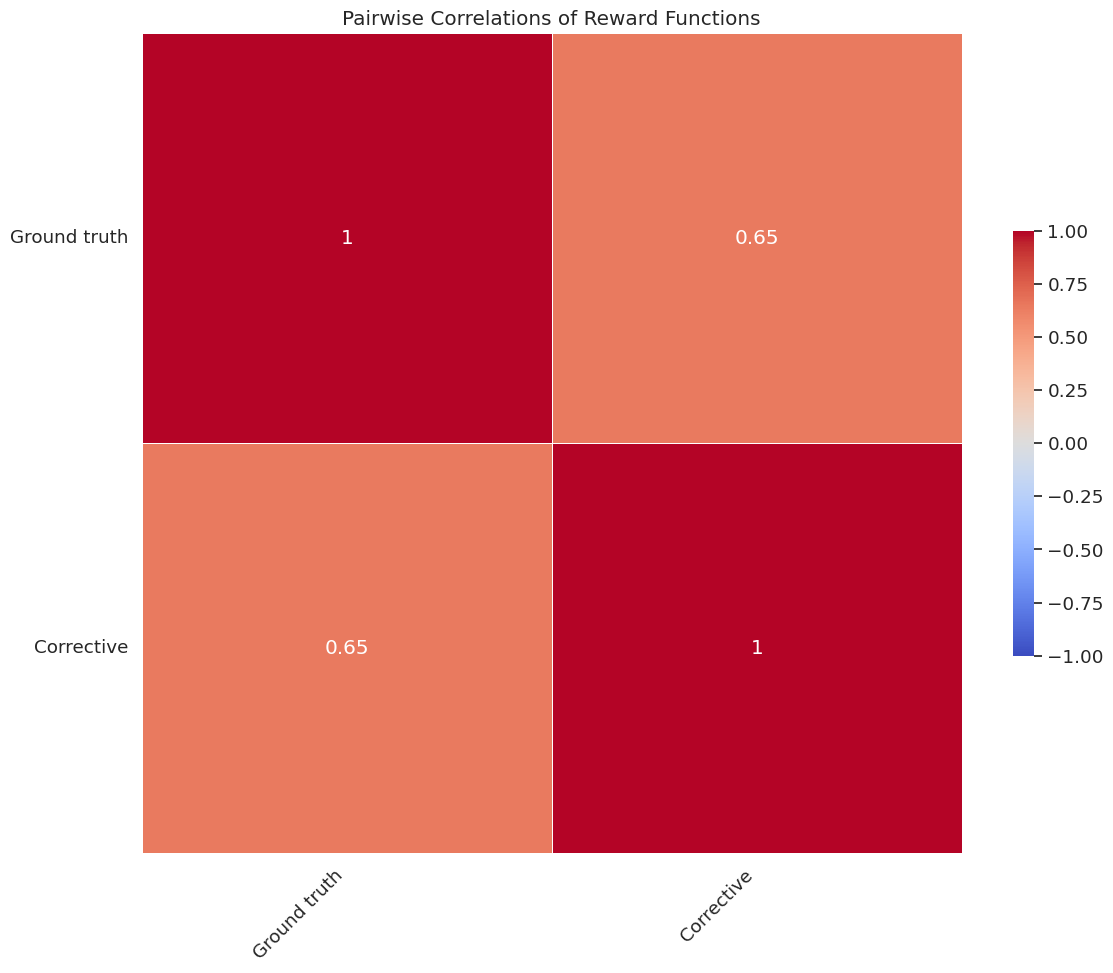

In [8]:
pairwise_correlation_heatmap(np.array(pred_rewards).squeeze(), [rt.capitalize() for rt in in_names])

### Pairwise Correlations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle

def pairwise_correlation_heatmap(rewards_list, names=None):
    # Ensure rewards_list is a list of numpy arrays
    rewards_list = [np.array(rewards).squeeze() for rewards in rewards_list]
    
    n_functions = rewards_list[0].shape[0]
    n_samples = len(rewards_list)
    
    # Initialize matrices for mean correlations and standard deviations
    mean_corr_matrix = np.zeros((n_functions, n_functions))
    std_corr_matrix = np.zeros((n_functions, n_functions))
    
    # Compute correlations for each sample
    for i in range(n_functions):
        for j in range(n_functions):
            correlations = []
            for rewards in rewards_list:
                corr, _ = pearsonr(rewards[i], rewards[j])
                correlations.append(corr)
            
            mean_corr_matrix[i, j] = np.mean(correlations)
            std_corr_matrix[i, j] = np.std(correlations)
    
    # Create heatmap
    plt.figure(figsize=(15, 12))
    sns.set(font_scale=1.2)
    
    # Plot mean correlations
    heatmap = sns.heatmap(mean_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Add standard deviations as text
    for i in range(n_functions):
        for j in range(n_functions):
            text = heatmap.text(j + 0.5, i + 0.5, f'\n±{std_corr_matrix[i, j]:.2f}',
                                ha='center', va='center', color='black', fontweight='bold')
            text.set_fontsize(8)
    
    # Set labels
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    plt.title('Pairwise Correlations of Reward Functions\n(Mean ± Std Dev)')
    plt.tight_layout()
    plt.show()

# Example usage
# pred_rewards_list = [np.array(...), np.array(...), ...]  # List of multiple pred_rewards arrays
# in_names = ['reward1', 'reward2', ...]
# pairwise_correlation_heatmap(pred_rewards_list, [name.capitalize() for name in in_names])

for 

## Distribution Analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


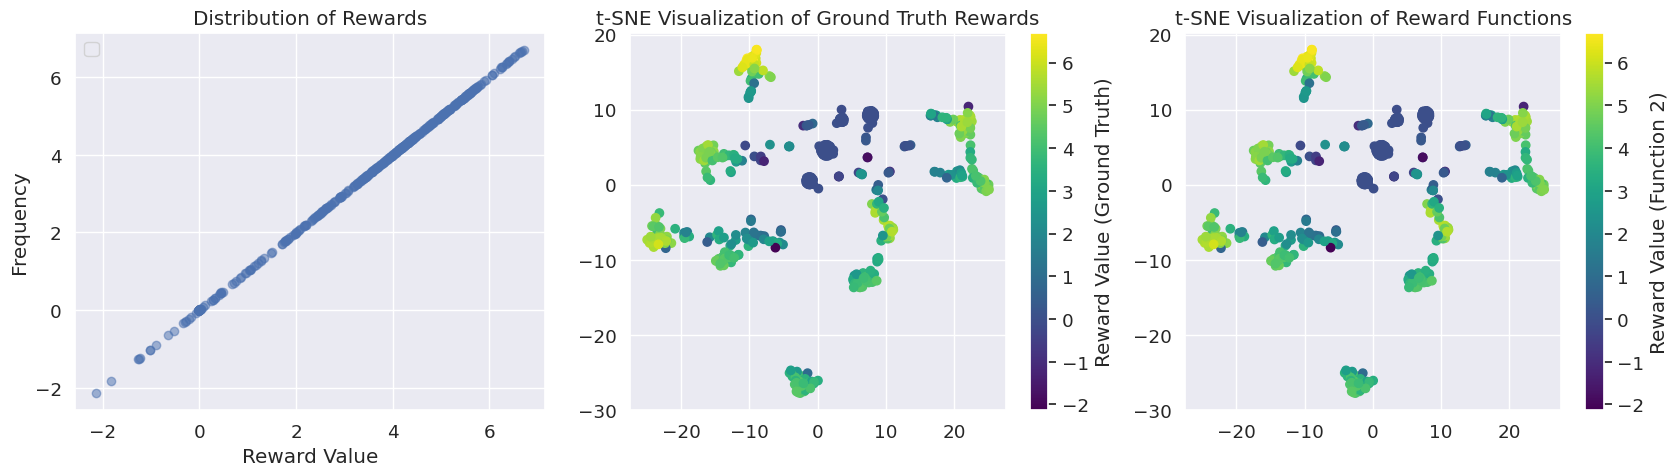

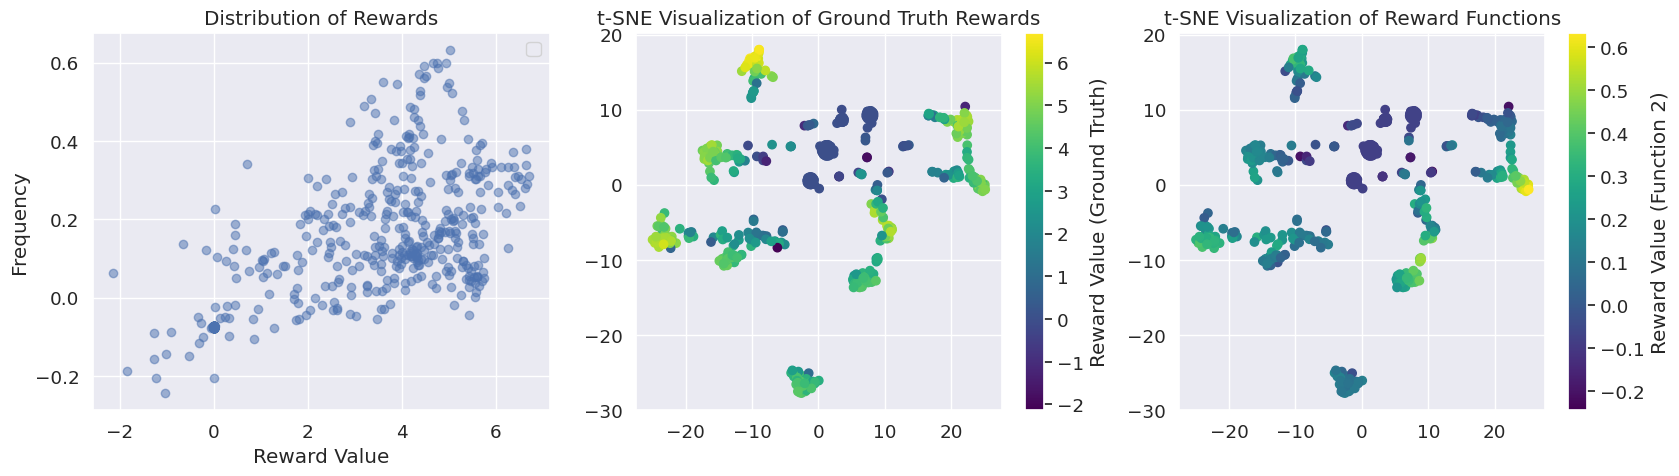

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def distribution_analysis(rewards1, rewards2, tsne_coordinates):
    
    # Histogram
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 3, 1)

    plt.scatter(rewards1, rewards2, alpha=0.5) #, label='Ground Truth Reward')
    #plt.hist(rewards2, bins=30, alpha=0.5, label='Learned Reward Function')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Rewards')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=rewards1, cmap='viridis')
    plt.colorbar(label='Reward Value (Ground Truth)')
    plt.title('t-SNE Visualization of Ground Truth Rewards')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=rewards2, cmap='viridis')
    plt.colorbar(label='Reward Value (Function 2)')
    plt.title('t-SNE Visualization of Reward Functions')
    plt.tight_layout()

# Example usage

# t-SNE visualization
tsne_input_data = np.array([np.concatenate(d) for d in input_data])
tsne = TSNE(n_components=2, random_state=42)
tsne_coordinates = tsne.fit_transform(tsne_input_data)

for i in range(len(pred_rewards)):
    distribution_analysis(pred_rewards[0], pred_rewards[i], tsne_coordinates)